# Computational Reproducibility of Jupyter Notebooks from Pubmed Central Publications

## General Statistics of the Study

Analyse the metadata collected from Pubmed Central publications that mentions Jupyter notebooks and GitHub.

In [66]:
import sys
sys.path.insert(0, '../archaeology')
sys.path.insert(0, '../analysis')

from pathlib import Path

import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client
from IPython.display import display
from matplotlib import pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from db import connect, Repository, Notebook, Query
import analysis_helpers, importlib
importlib.reload(analysis_helpers)
from analysis_helpers import var, relative_var, savefig

%matplotlib inline

In [67]:
# Create folder for outputs
OUTPUT_DIR = 'Outputs'
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Journals

In [68]:
with connect() as session:    
    journals = pd.read_sql_table('journal', session.connection())

In [69]:
journals.head(5)

,id,name,nlm_ta,iso_abbrev,issn_epub,publisher_name,publisher_loc
0,1,BMC Medical Imaging,BMC Med Imaging,BMC Med Imaging,1471-2342,BioMed Central,London
1,2,Nature,Nature,Nature,1476-4687,Nature Publishing Group UK,London
2,3,PLoS ONE,PLoS One,PLoS One,1932-6203,Public Library of Science,"San Francisco, CA USA"
3,4,PLoS Computational Biology,PLoS Comput Biol,PLoS Comput Biol,1553-7358,Public Library of Science,"San Francisco, CA USA"
4,5,eLife,eLife,Elife,2050-084X,"eLife Sciences Publications, Ltd",None


#### Journal Count

In [70]:
# Total Number of Journals
print('Journals: {}'.format(var("journals", len(journals), "{:,}")))

Journals: 373


## Articles

In [71]:
with connect() as session:    
    articles = pd.read_sql_table('article', session.connection())

In [72]:
articles.head(3)

,id,journal_id,name,pmid,pmc,publisher_id,doi,subject,published_date,received_date,accepted_date,license_type,copyright_statement,keywords,repositories
0,1,1,Sensitivity analysis for interpretation of mac...,33588786.0,7885570,551,10.1186/s12880-021-00551-1,Software,2021-02-15,2020-10-20,2021-01-24,OpenAccess,© The Author(s) 2021,Deep learning;Neural networks;Cardiac magnetic...,https://github.com/chfc-cmi/misas;https://gith...
1,2,2,Giant lungfish genome elucidates the conquest ...,33461212.0,7875771,3198,10.1038/s41586-021-03198-8,Article,2021-01-18,2020-07-13,2021-01-06,OpenAccess,© The Author(s) 2021,Evolutionary genetics;Phylogenetics;Evolutiona...,https://github.com/schloi/MARVEL;https://githu...
2,3,3,Tracking individual honeybees among wildflower...,33571210.0,7877608,PONE-D-20-27840,10.1371/journal.pone.0239504,Research Article,2021-02-11,2020-09-04,2021-01-18,http://creativecommons.org/licenses/by/4.0/,© 2021 Ratnayake et al,,https://github.com/malikaratnayake/HyDaT_Track...


#### Article Count

In [73]:
# Total Number of Articles
print('Articles: {}'.format(var("articles", len(articles), "{:,}")))

Articles: 1,419


## Repositories

In [74]:
with connect() as session:    
    repositories = pd.read_sql_table('repositories', session.connection())

In [75]:
repositories.head(3)

,id,article_id,domain,repository,hash_dir1,hash_dir2,commit,notebooks_count,setups_count,requirements_count,notebooks,setups,requirements,processed,pipfiles_count,pipfile_locks_count,pipfiles,pipfile_locks
0,1,1,github.com,chfc-cmi/misas,fb,72c1f535128c3590fbc4947125801710adfc1e,a67e0dbc7c7dbb078f7624fc790564bb6d929b71,8,1,0,07_myops.ipynb;06_pneumothorax.ipynb;index.ipy...,setup.py,,8329,0,0,,
1,2,1,github.com,minimaxir/optillusion-animation,10,7e04a9d586713ecaddfb2e4c31f9adc1c6571c,7cf74ea556490d0eaa18916797b9d8e72411ddf4,0,0,0,,,,8329,0,0,,
2,3,2,github.com,schloi/MARVEL,c3,83cf4529160791c97340ab4d5ea091501c3451,e3f3cae82cec91ee0040889c6b5d283e50254b51,0,0,0,,,,141,0,0,,


#### Repositories Count

In [76]:
# Total Number of Repositories
print('Repositories: {}'.format(var("repositories", len(repositories), "{:,}")))

Repositories: 2,177


## Journals with highest number of articles with mention of Github repository and notebook

In [77]:
with connect() as session:
    query = (
        "SELECT j.name as journal_name, j.nlm_ta, j.iso_abbrev "
        "from journal j, article a where a.journal_id=j.id"
    )
    df = pd.read_sql(query, session.connection())
    df['journal_abbrev'] = np.where(df['nlm_ta']== '', df['iso_abbrev'], df['nlm_ta'])
    df['journal_abbrev'] = np.where(df['journal_abbrev']== '', df['journal_name'], df['journal_abbrev'])
    articles_per_journal = df['journal_abbrev'].value_counts()
    

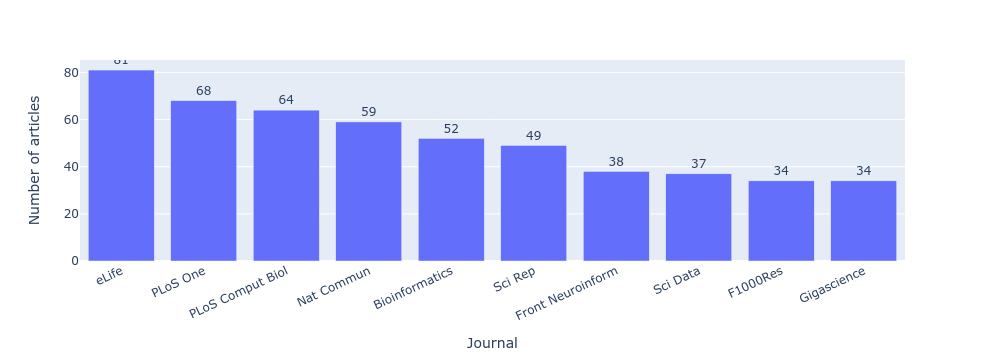

In [78]:
# Articles per Journal
index_label = 'Journal'
number_label = 'Number of articles'
filename = 'top_journals_with_articles'
articles_per_journal.columns = [index_label, number_label]
articles_per_journal_df = pd.DataFrame({'Journal':articles_per_journal.index, number_label:articles_per_journal.values})
fig = px.bar(articles_per_journal_df.head(10), index_label, number_label, text=number_label)
fig.update_traces(texttemplate='%{text:s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-25)
fig.write_image(OUTPUT_DIR + '/' + filename + '.pdf', scale=1.0)    
fig.show()

# Journals by number of Github repositories with Jupyter Notebooks

In [79]:
with connect() as session:
    query = (
        "SELECT j.name as journal_name, j.nlm_ta, j.iso_abbrev, r.notebooks_count "
        "from journal j, article a, repositories r where a.journal_id=j.id and a.id=r.article_id"
    )
    df = pd.read_sql(query, session.connection())    
    df['journal_abbrev'] = np.where(df['nlm_ta']== '', df['iso_abbrev'], df['nlm_ta'])
    df['journal_abbrev'] = np.where(df['journal_abbrev']== '', df['journal_name'], df['journal_abbrev']) 

In [80]:
repositories_per_journal_df = df['journal_abbrev'].value_counts().reset_index()
repositories_per_journal_df.columns = ['journal_abbrev', 'repositories_count']
repositories_per_journal_df.head()

,journal_abbrev,repositories_count
0,eLife,202
1,PLoS Comput Biol,130
2,PLoS One,127
3,Nat Commun,120
4,Gigascience,102


In [81]:
repositories_with_notebooks_per_journal_df = df[df['notebooks_count'] > 0]
repositories_with_notebooks_per_journal_df = repositories_with_notebooks_per_journal_df['journal_abbrev'].value_counts().reset_index()
repositories_with_notebooks_per_journal_df.columns = ['journal_abbrev', 'repositories_with_notebooks_count']
repositories_with_notebooks_per_journal_df.head()

,journal_abbrev,repositories_with_notebooks_count
0,eLife,137
1,PLoS Comput Biol,68
2,PLoS One,68
3,Nat Commun,58
4,Sci Data,48


In [82]:
min_df = df.groupby('journal_abbrev')['notebooks_count'].min().reset_index()
min_df.columns = ['journal_abbrev', 'min_notebooks_count']
max_df = df.groupby('journal_abbrev')['notebooks_count'].max().reset_index()
max_df.columns = ['journal_abbrev', 'max_notebooks_count']
jounral_min_max_nb_df = pd.merge(min_df, max_df, on="journal_abbrev", how="outer")
jounral_min_max_nb_df.head()

,journal_abbrev,min_notebooks_count,max_notebooks_count
0,ACS Energy Lett,3,3
1,Acta Crystallogr D Struct Biol,7,7
2,Adv Sci (Weinh),0,0
3,Adv Struct Chem Imaging,0,7
4,Advances in Information Retrieval,0,0


In [83]:
repo_with_without_nb_df = pd.merge(repositories_per_journal_df, repositories_with_notebooks_per_journal_df, on="journal_abbrev", how="outer")
repo_with_without_nb_df.head()

,journal_abbrev,repositories_count,repositories_with_notebooks_count
0,eLife,202,137.0
1,PLoS Comput Biol,130,68.0
2,PLoS One,127,68.0
3,Nat Commun,120,58.0
4,Gigascience,102,30.0


In [84]:
repositories_journal_df = pd.merge(repo_with_without_nb_df, jounral_min_max_nb_df, on="journal_abbrev", how="outer")
repositories_journal_df.head()

,journal_abbrev,repositories_count,repositories_with_notebooks_count,min_notebooks_count,max_notebooks_count
0,eLife,202,137.0,0,61
1,PLoS Comput Biol,130,68.0,0,115
2,PLoS One,127,68.0,0,87
3,Nat Commun,120,58.0,0,260
4,Gigascience,102,30.0,0,79


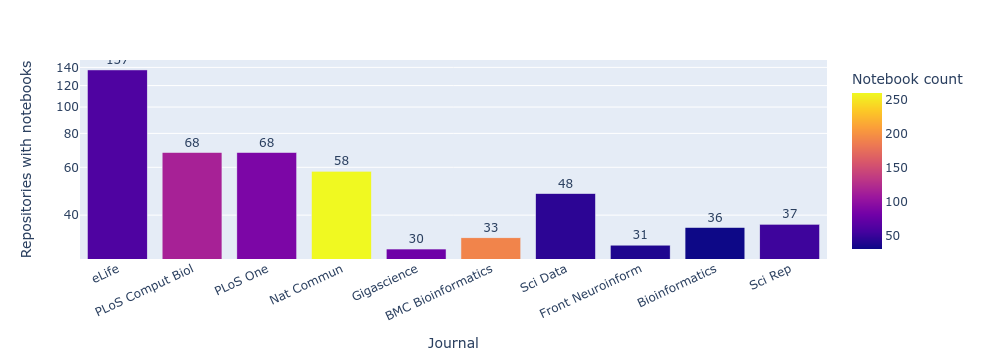

In [85]:
fig = px.bar(repositories_journal_df.head(10), x='journal_abbrev', y='repositories_with_notebooks_count', color='max_notebooks_count',
             labels=dict(journal_abbrev="Journal", repositories_count="Total repositories", repositories_with_notebooks_count="Repositories with notebooks", 
                         min_notebooks_count="Min notebook count", max_notebooks_count="Notebook count"),
        hover_data=['repositories_count', 'min_notebooks_count'], 
)
filename = 'top_journals_with_repositories_notebooks'
fig.update_traces(texttemplate='%{y:s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-25, 
                  xaxis_title = 'Journal', yaxis_title = 'Repositories with notebooks', yaxis_type = 'log')    
fig.write_image(OUTPUT_DIR + '/' + filename + '.pdf', scale=1.0)

fig.show()

### Journals by the number of GitHub repositories and by the number of GitHub repositories with at least one Jupyter notebook

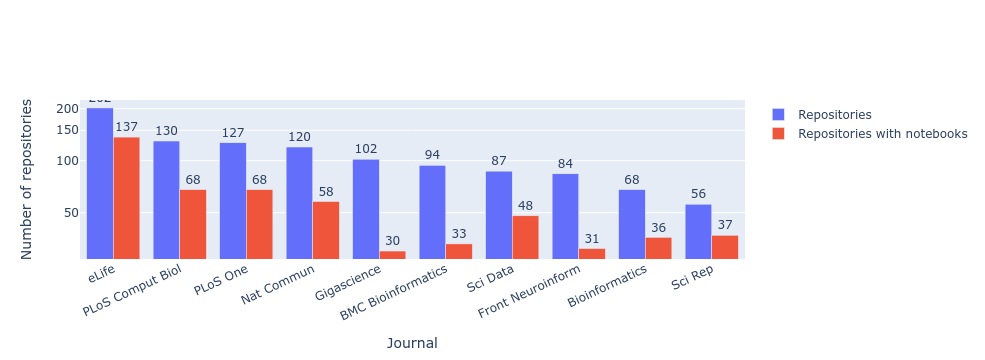

In [86]:
repositories_journal_df = repositories_journal_df.head(10)
fig = go.Figure()
fig.add_trace(go.Bar(
    x=repositories_journal_df['journal_abbrev'],
    y=repositories_journal_df['repositories_count'],
    name='Repositories',
))
fig.add_trace(go.Bar(
    x=repositories_journal_df['journal_abbrev'],
    y=repositories_journal_df['repositories_with_notebooks_count'],
    name='Repositories with notebooks',
))

filename = 'top_journals_repositories_with_without_notebooks'
xaxis_title = 'Journal'
yaxis_title = 'Number of repositories'
fig.update_traces(texttemplate='%{y:s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-25, 
                  xaxis_title = xaxis_title, yaxis_title = yaxis_title, yaxis_type = 'log')    
fig.write_image(OUTPUT_DIR + '/' + filename + '.pdf', scale=1.0)

fig.show()

## Articles by published year

In [87]:
with connect() as session:
    query = (
        "SELECT j.id as journal_id, j.name as journal_name, j.nlm_ta, j.iso_abbrev, a.id as article_id, a.name as article_name, a.pmc as article_pmc, a.published_date, a.accepted_date, a.received_date, r.id as repository_id, r.notebooks_count "
        "from journal j, article a, repositories r where a.journal_id=j.id and a.id=r.article_id"
    )
    df = pd.read_sql(query, session.connection())
    df['article_date'] = np.where(df['published_date']== '', df['accepted_date'], df['published_date'])
    df['article_date'] = np.where(df['article_date']== '', df['received_date'], df['article_date'])
    df['published_year'] = pd.DatetimeIndex(df['article_date']).strftime('%Y')
    df['journal_abbrev'] = np.where(df['nlm_ta']== '', df['iso_abbrev'], df['nlm_ta'])
    df['journal_abbrev'] = np.where(df['journal_abbrev']== '', df['journal_name'], df['journal_abbrev'])


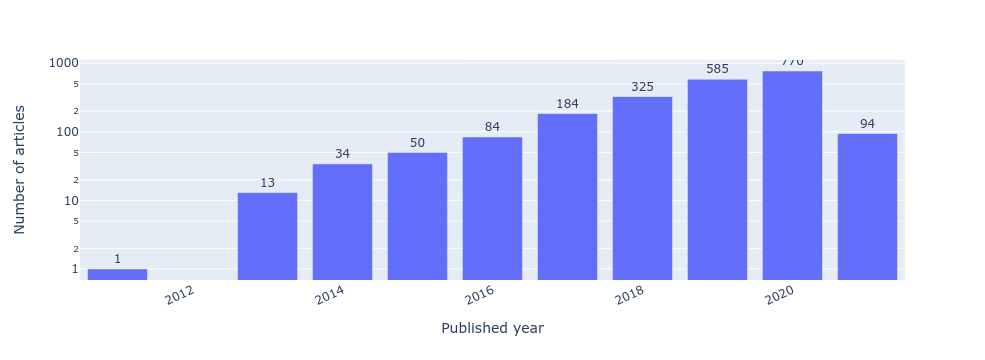

In [88]:
# Articles per year
articles_per_year = df['published_year'].value_counts()
index_label = 'Published year'
number_label = 'Number of articles'
articles_per_year.columns = [index_label, number_label]
articles_per_year_df = pd.DataFrame({index_label:articles_per_year.index, number_label:articles_per_year.values})
filename = 'timeline_articles'
fig = px.bar(articles_per_year_df, index_label, number_label, text=number_label)
fig.update_traces(texttemplate='%{text:s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-25, xaxis_type='date', yaxis_type='log')
fig.write_image(OUTPUT_DIR + '/' + filename + '.pdf', scale=1.0)
fig.show()

## Articles by number of GitHub repositories with at least one Jupyter notebook by year

In [89]:
articles_repos_journal_df = df[['journal_abbrev', 'article_pmc', 'published_year', 'notebooks_count']]

articles_per_year_df = articles_repos_journal_df
articles_per_year_df = articles_per_year_df['published_year'].value_counts().reset_index()
articles_per_year_df.columns = ['published_year', 'articles_count']
articles_per_year_df.head()

,published_year,articles_count
0,2020,770
1,2019,585
2,2018,325
3,2017,184
4,2021,94


In [90]:
articles_with_notebooks_per_year_df = df[df['notebooks_count'] > 0]
articles_with_notebooks_per_year_df = articles_with_notebooks_per_year_df['published_year'].value_counts().reset_index()
articles_with_notebooks_per_year_df.columns = ['published_year', 'articles_with_notebooks_count']
articles_with_notebooks_per_year_df.head()

,published_year,articles_with_notebooks_count
0,2020,419
1,2019,287
2,2018,156
3,2017,100
4,2021,48


In [91]:
article_with_without_nb_df = pd.merge(articles_per_year_df, articles_with_notebooks_per_year_df, on="published_year", how="outer")
article_with_without_nb_df.head()

,published_year,articles_count,articles_with_notebooks_count
0,2020,770,419.0
1,2019,585,287.0
2,2018,325,156.0
3,2017,184,100.0
4,2021,94,48.0


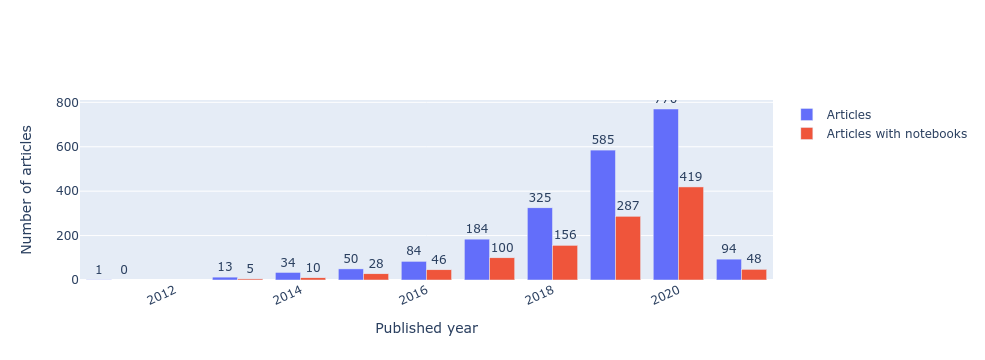

In [92]:
article_with_without_nb_df = article_with_without_nb_df.head(10)
fig = go.Figure()
fig.add_trace(go.Bar(
    x=article_with_without_nb_df['published_year'],
    y=article_with_without_nb_df['articles_count'],
    name='Articles',
))
fig.add_trace(go.Bar(
    x=article_with_without_nb_df['published_year'],
    y=article_with_without_nb_df['articles_with_notebooks_count'],
    name='Articles with notebooks',
))

filename = 'timeline_articles_with_without_notebooks'
xaxis_title = 'Published year'
yaxis_title = 'Number of articles'
fig.update_traces(texttemplate='%{y:s}', textposition='outside')
fig.update_layout(uniformtext_minsize=4, uniformtext_mode='hide', xaxis_tickangle=-25, xaxis_type='date', xaxis_title = xaxis_title, yaxis_title = yaxis_title)    
fig.write_image(OUTPUT_DIR + '/' + filename + '.pdf', scale=1.0)
fig.show()

## Articles with Author ORCID

In [93]:
with connect() as session:
    query = (
        "SELECT a.id as article_id, au.id as author_id, au.orcid, a.published_date, a.name as article_name, au.name as name, au.given_names as given_names, a.accepted_date, a.received_date "
        "from article a, author au where au.article_id=a.id"
    )
    df = pd.read_sql(query, session.connection())
    df['article_date'] = np.where(df['published_date']== '', df['accepted_date'], df['published_date'])
    df['article_date'] = np.where(df['article_date']== '', df['received_date'], df['article_date'])
    df['published_year'] = pd.DatetimeIndex(df['article_date']).strftime('%Y')
    df['author_full_name'] = df['name'] + ' ' + df['given_names']

In [94]:
authors_with_orcid_df = df.groupby(['published_year'])['orcid'].size().sort_values(ascending=False)
index_label = 'Published year'
number_label = 'Number of Authors with ORCID'
authors_with_orcid_df.columns = [index_label, number_label]
authors_with_orcid_df.head()

published_year
2020    3545
2019    2776
2017    1706
2018    1701
2016     710
Name: orcid, dtype: int64

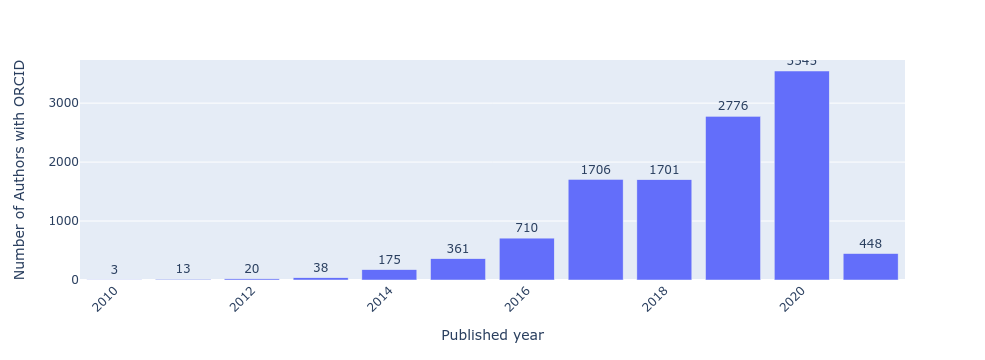

In [95]:
newdf = pd.DataFrame({index_label:authors_with_orcid_df.index, number_label:authors_with_orcid_df.values})
newdf.head()
filename = 'timeline_authors_with_orcid'

fig = px.bar(newdf, x=index_label, y=number_label, text=number_label)
fig.update_traces(texttemplate='%{text:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_type = 'date', xaxis_tickangle=-45)
fig.show()
fig.write_image(OUTPUT_DIR + '/' + filename + '.pdf')

In [96]:
notebook_trend_df = pd.merge(articles_with_notebooks_per_year_df, authors_with_orcid_df, on="published_year", how="outer")
notebook_trend_df.dropna(inplace=True)
notebook_trend_df.head(10)

,published_year,articles_with_notebooks_count,orcid
0,2020,419.0,3545
1,2019,287.0,2776
2,2018,156.0,1701
3,2017,100.0,1706
4,2021,48.0,448
5,2016,46.0,710
6,2015,28.0,361
7,2014,10.0,175
8,2013,5.0,38


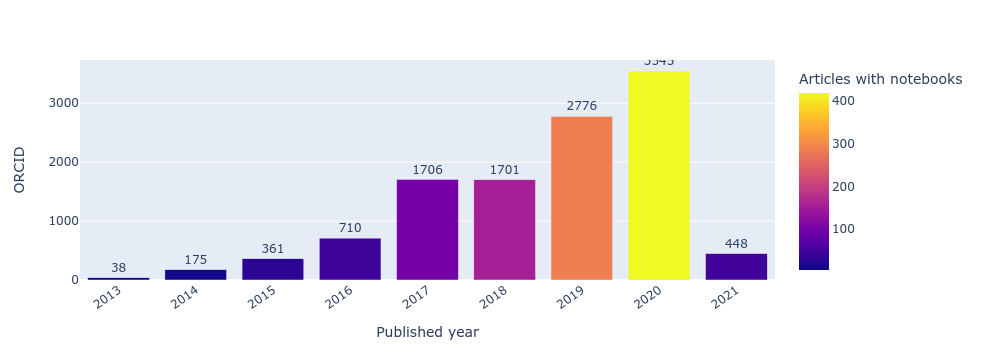

In [97]:
fig = px.bar(notebook_trend_df, x='published_year', y='orcid', color='articles_with_notebooks_count',
            labels=dict(published_year="Published year", orcid="ORCID", articles_with_notebooks_count="Articles with notebooks")
            )
fig.update_traces(texttemplate='%{y:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_type = 'date', xaxis_tickangle=-35)
fig.show()
filename = 'timeline_articles_authors_with_orcid'
fig.write_image(OUTPUT_DIR + '/' + filename + '.pdf')